<a href="https://colab.research.google.com/github/wfwiggins/RSNA-NLP-2020/blob/master/RSNA20_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSNA 2020: Hands-on AI for Non-Coders**

## **Basics of Information Extraction from Radiology Reports**

In this demonstration, we will utilize techniques of _natural language processing_ (NLP) to train a classifier, which will analyze the text of radiology reports for chest radiographs to predict whether a report is **normal** or **abnormal**.

### Code
We will utilize the [fast.ai v2 library](https://docs.fast.ai/), written primarily by Jeremy Howard and Sylvain Gugger (with help from many others). It is written in the [Python programming language](https://www.python.org/) and built on top of the [PyTorch deep learning library](https://www.pytorch.org/).

The demonstration in this notebook relies heavily on examples from the `fast.ai` book, _Deep Learning for Coders with fastai and PyTorch: AI Applications without a PhD_ by Jeremy Howard and Sylvain Gugger, which was written entirely in Jupyter notebooks, which are [freely available for download on GitHub](https://github.com/fastai/fastbook). A print copy of the book can be purchased from Amazon.

### Data

The data is obtained from the National Library of Medicine's Open-i service. We utilize the radiology reports from the [Indiana University Chest X-ray Dataset](https://openi.nlm.nih.gov/faq#collection) for this demonstration.

> _Reference:_ Demner-Fushman D, Kohli MD, Rosenman MB, Shooshan SE, Rodriguez L, Antani S, Thoma GR, McDonald CJ. Preparing a collection of radiology examinations for distribution and retrieval. J Am Med Inform Assoc. 2016 Mar;23(2):304-10. doi: 10.1093/jamia/ocv080. Epub 2015 Jul 1. 

### Developers
- Walter F. Wiggins, MD, PhD - Duke University Hospital, Durham, NC, USA
- Felipe Kitamura, MD - UNIFESP, Sao Paulo, Brasil
- Igor Santos, MD - UNIFESP, Sao Paulo, Brasil
- Luciano M. Prevedello, MD, MPH - Ohio State University, Columbus, OH, USA

# System Setup & Downloading the Data

**_FIRST_: Make sure you have the runtime type set to "GPU".**

<img src="https://github.com/wfwiggins/RSNA-NLP-2020/blob/master/images/set_runtime_gpu.gif?raw=true">

When you run the following cell, three things will happen:
1. The necessary code libraries will be installed.
2. Next, the [NLM Open-i "Indiana University Chest X-ray Reports" dataset](https://openi.nlm.nih.gov/faq#collection) will be downloaded.
3. Finally, the system will restart. This _WILL_ generate an error message, which can safely be ignored 😉.

In [ ]:
#@title **Setting up the runtime environment...**

import os

# Install libraries
!pip install fastai --upgrade >/dev/null
!pip install xmltodict >/dev/null

# Download the data
!curl -s https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz | tar xvz >/dev/null

# Restart the runtime
os.kill(os.getpid(), 9)

# Reformatting the Data

Each of the reports is stored in _extensible markup language_ (XML) format. In order to work with the report text data more easily, we will extract the data and put it into a `pandas.DataFrame`, which is a tabular data structure.

The XML metadata contains [MeSH terms](https://www.ncbi.nlm.nih.gov/mesh/) for each report. We will use these to create the _label_ for each report in our dataset. These labels will serve as the targets for training our classifier to predict whether the report is **normal** or **abnormal**.

In [1]:
#@title **Extracting the data...**

#@markdown After the relevant data is extracted from the XML files, the total number of reports and the first 5 rows of our data table will show up below.

import glob
import xmltodict
from fastai.basics import *

def xml_parse(f):
    with open(f) as xml:
        report_dict = xmltodict.parse(xml.read())
    xml.close()
    return report_dict

def get_label(report):
    label = L(report['eCitation']['MeSH']['major'])
    return 'normal' if label[0].lower() == 'normal' else 'abnormal'

def get_text(report):
    text_dict = {}
    text = report['eCitation']['MedlineCitation']['Article']['Abstract']['AbstractText']
    findings = text[2]['#text'] if '#text' in text[2] else ''
    text_dict['findings'] = findings
    impression = text[3]['#text'] if '#text' in text[3] else ''
    text_dict['impression'] = impression
    text_dict['full-text'] = ' '.join([findings, impression])
    return text_dict

def process_report(report):
    label = get_label(report)
    report_dict = get_text(report)
    report_dict['label'] = label
    return report_dict

fps = L(glob.glob('/content/ecgen-radiology/*'))
reports = fps.map(xml_parse)
reports_df = pd.DataFrame(reports.map(process_report))
print('# of reports:', reports_df.shape[0])
print()
reports_df.head()

# of reports: 3955



,findings,impression,full-text,label
0,Stable borderline enlarged cardiac contour. Calcified mediastinal lymph XXXX. Prominent right paratracheal stripe. Emphysema. No active pulmonary disease. Mild spondylosis.,"Stable appearance of the chest, see above.","Stable borderline enlarged cardiac contour. Calcified mediastinal lymph XXXX. Prominent right paratracheal stripe. Emphysema. No active pulmonary disease. Mild spondylosis. Stable appearance of the chest, see above.",abnormal
1,"There has been interval increase in size of the cardiac silhouette from XXXX. The cardiac fluid is now mildly enlarged. Pulmonary vasculature is increased with mildly increased interstitial markings and fissural thickening, suggesting mild pulmonary edema. There is no focal airspace disease, pneumothorax, or large pleural effusion. Descending thoracic aorta is tortuous. There are no acute bony findings.",Cardiomegaly which appears XXXX from XXXX with probable mild pulmonary edema. .,"There has been interval increase in size of the cardiac silhouette from XXXX. The cardiac fluid is now mildly enlarged. Pulmonary vasculature is increased with mildly increased interstitial markings and fissural thickening, suggesting mild pulmonary edema. There is no focal airspace disease, pneumothorax, or large pleural effusion. Descending thoracic aorta is tortuous. There are no acute bony findings. Cardiomegaly which appears XXXX from XXXX with probable mild pulmonary edema. .",abnormal
2,"Heart size within normal limits, stable mediastinal contours, mediastinal clips, left base pleural-parenchymal irregularity compatible with scarring. No focal alveolar consolidation, no definite pleural effusion seen. No typical findings of pulmonary edema. Chronic appearing left rib contour irregularities may be posttraumatic or postsurgical.",No acute findings,"Heart size within normal limits, stable mediastinal contours, mediastinal clips, left base pleural-parenchymal irregularity compatible with scarring. No focal alveolar consolidation, no definite pleural effusion seen. No typical findings of pulmonary edema. Chronic appearing left rib contour irregularities may be posttraumatic or postsurgical. No acute findings",abnormal
3,The lungs are clear. No focal airspace consolidation. No pleural effusion or pneumothorax. Heart size and mediastinal contour are within normal limits.,No evidence of active disease.,The lungs are clear. No focal airspace consolidation. No pleural effusion or pneumothorax. Heart size and mediastinal contour are within normal limits. No evidence of active disease.,normal
4,Lungs are clear. There is no pneumothorax or pleural effusion. The heart and mediastinum are within normal limits. Bony structures are intact.,No acute cardiopulmonary process.,Lungs are clear. There is no pneumothorax or pleural effusion. The heart and mediastinum are within normal limits. Bony structures are intact. No acute cardiopulmonary process.,normal


# Exploring the data

As you'll see in the table above, there are some reports where the "Impression" states something along the lines of "No acute cardiopulmonary abnormality" but the label is "abnormal". This is usually due to a chronic incidental finding or artifact that is mentioned in the "Findings", but isn't included in the "Impression".

> We'll revisit this point later when we're deciding which text from the report we want to use to train our classifier.

For now, let's look through a little more of the data and see how many normals and abnormals we have to work with.

In [2]:
#@title **Run this cell several times to view random samples of the data**

reports_df.sample(5)

,findings,impression,full-text,label
2744,"Heart size normal. Lungs are clear. XXXX are normal. No pneumonia, effusions, edema, pneumothorax, adenopathy, nodules or masses.",Normal chest.,"Heart size normal. Lungs are clear. XXXX are normal. No pneumonia, effusions, edema, pneumothorax, adenopathy, nodules or masses. Normal chest.",normal
3194,"The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia.",No acute cardiopulmonary disease.,"The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. No acute cardiopulmonary disease.",normal
3440,Chronic bilateral emphysematous changes. The heart size and mediastinal silhouette are within normal limits for contour. The lungs are clear. No pneumothorax or pleural effusions. The XXXX are intact.,Significant bilateral emphysematous changes. No acute cardiopulmonary abnormalities.,Chronic bilateral emphysematous changes. The heart size and mediastinal silhouette are within normal limits for contour. The lungs are clear. No pneumothorax or pleural effusions. The XXXX are intact. Significant bilateral emphysematous changes. No acute cardiopulmonary abnormalities.,abnormal
1681,"Heart size is normal. Cardiomediastinal silhouette stable. No pneumothorax, pleural effusion, or focal airspace disease. Nodular densities consistent with chronic granulomatous disease. Bony structures appear intact. Emphysema.",Negative for acute cardiopulmonary disease. No pulmonary nodules identified.,"Heart size is normal. Cardiomediastinal silhouette stable. No pneumothorax, pleural effusion, or focal airspace disease. Nodular densities consistent with chronic granulomatous disease. Bony structures appear intact. Emphysema. Negative for acute cardiopulmonary disease. No pulmonary nodules identified.",abnormal
806,The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. There are T-spine osteophytes. XXXX calcified granuloma in the right apex.,No acute cardiopulmonary abnormality.,The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. There are T-spine osteophytes. XXXX calcified granuloma in the right apex. No acute cardiopulmonary abnormality.,abnormal


Here are some of the things you may have noticed about the data, as you reviewed it:
- Some reports only have an Impression (i.e. no separate Findings section)
- Many reports contain blocks of "XXXX" text. This is due to the fact that these reports were anonymized prior to releasing them as an open data set. These blocks likely represent _named entities_ or dates.
- As expected, there is wide variation in the length of these chest radiograph reports.

---

Next, let's count how many of each label we have.


Abnormal: 2564
Normal: 1391



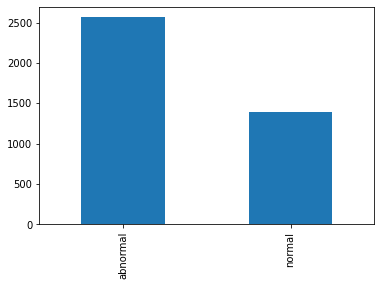

In [3]:
#@title **Label counts: # of Normals & Abnormals**

label_counts = reports_df.label.value_counts()
print('Abnormal:', label_counts['abnormal'])
print('Normal:', label_counts['normal'])
print()
label_counts.plot.bar();

As we see in the bar graph above, there are almost twice as many abnormal reports as there are normal reports. This will be important to remember as we partition our data into training, validation, and test sets.

In fact, we'll go ahead and split off ("hold out") the test set right now to ensure our model is not exposed to it until the very end. 

We'll set it up such that the our test set is 15% of our full data set and keep the relative percentage of labels the same as in our full dataset.

Test set size: 594
Abnormal: 385
Normal: 209



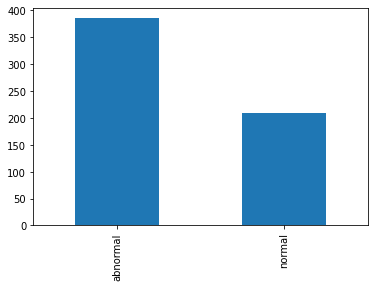

In [4]:
#@title **Test set label counts**

from sklearn.model_selection import train_test_split

np.random.seed(42)

train_val, test_df = train_test_split(reports_df, test_size=0.15, stratify=reports_df.label.values)
train_val.reset_index(inplace=True)
test_df.reset_index(inplace=True)
print('Test set size:', test_df.shape[0])
test_counts = test_df.label.value_counts()
print('Abnormal:', test_counts['abnormal'])
print('Normal:', test_counts['normal'])
print()
test_counts.plot.bar();

# Language Modeling

The types of algorithms we use in NLP work with with numbers, not text. Therefore, we need a way to convert text into numbers.

## Tokenization

_Tokenization_ is the process by which we split text into chunks or _tokens_. An individual token could be a sentence or phrase, a word, a part of a word, or a single character. Most often, we choose to tokenize at the word or sub-word level.

Each token is assigned a sequential integer value and the collection of token-integer pairs is called our _vocabulary_.

## Embedding

While these integers map one-to-one onto our tokens, their numeric value is otherwise meaningless. To embed more information into the numeric representation of our tokens, we employ a process called _language modeling_. We can either use a pre-trained language model for this _embedding_ or we can fine-tune a language model to better model our "radiology language". This latter process is called _transfer learning_.

In [5]:
#@title **Word Tokenization**

from fastai.text.all import *

spacy = WordTokenizer()
text = train_val.loc[0, 'full-text']
print('Original text:')
print(text)
print()
tkns = first(spacy([text]))
print('After word tokenization (only showing first 10 tokens):')
print(coll_repr(tkns))

Original text:
The heart and lungs have XXXX XXXX in the interval. Both lungs are clear and expanded. Heart and mediastinum normal. No active disease.

After word tokenization (only showing first 10 tokens):
(#27) ['The','heart','and','lungs','have','XXXX','XXXX','in','the','interval'...]


In [6]:
#@title **fast.ai Tokenization**

tkn = Tokenizer(spacy)
toks = tkn(text)
print(coll_repr(toks, 15))

(#36) ['xxbos','xxmaj','the','heart','and','lungs','have','xxrep','4','x','xxrep','4','x','in','the'...]


## Added features from fast.ai

You'll notice some odd-appearing tokens in the above output. These are special tokens that indicate certain things about the text.
- `'xxbos'` indicates the beginning of the text _stream_
- `'xxmaj'` indicates that the following character was capitalized before fast.ai lowered it
- `'xxrep'` followed by `'4', 'x'` means that `'x'` is repeated 4 times...the `XXXX` in the reports is a product of the _anonymization_ process that the team who generated the dataset used 

These special tokens enrich the data while reducing the vocab by eliminating redundant upper and lower case variants of individual words.

## Numericalization

Now that we've converted our text to tokens, the next step in embedding is to convert each unique token to a number.

For language modeling, we can do this on all of the text that we intend to use for training and validation. So we'll combine the **Findings** and **Impression** for each of our reports and tokenize the text to define our _vocabulary_. Each token in the vocabulary will be identified by a unique number.

In [7]:
#@title **Computing vocabulary...**

txts = L(train_val['full-text'].to_list())
toks = txts.map(tkn)
num = Numericalize()
num.setup(toks)
coll_repr(num.vocab, 20)

"(#1176) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','.','no','the','is','are','normal',',','4','x','and','of'...]"

As you can see above, we have 1,168 tokens in our vocabulary. The special tokens from `fast.ai` appear first, followed by every other token in order of decreasing frequency. By default, `fast.ai` only includes tokens that appear at least 3 times in the _corpus_ (collection of texts). 

In [8]:
#@title **Numericalizing tokens...**

nums = num(toks[0][:14])
print(nums)
print(' '.join(num.vocab[i] for i in nums))

TensorText([  2,   8,  11,  25,  18,  27, 212,   5,  16,  17,   5,  16,  17,  32])
xxbos xxmaj the heart and lungs have xxrep 4 x xxrep 4 x in


Here, we see a subset of the numericalized tokens (top) with their corresponding word tokens (bottom) from the first report in our _corpus_. 

## Language Model Transfer Learning

By default, `fastai.text` uses a language model pre-trained on the WikiText-103 corpus, which is a frequently used benchmark for NLP models, similar to ImageNet for image classification models.

In their 2018 ACL paper "[Universal Language Model Fine-Tuning for Text Classification](https://arxiv.org/abs/1801.06146)", Jeremy Howard and Sebastian Ruder proposed the ULM-FiT approach of fine-tuning the language model on the corpus on which we will train our text classification model.

Here, we will fine-tune the language model in two stages.

> **NOTE:** This portion of the notebook takes between 3 and 10 minutes to run. It's ok to skip this section for now and jump ahead to "Report Classifier Training".

In [12]:
#@title **Fine-tuning the language model...**

dls_lm = TextDataLoaders.from_df(train_val, valid_pct=0.3, seed=42, text_col='full-text', is_lm=True)
learn_lm = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()]).to_fp16()

# Train the final layers of the network
learn_lm.fit_one_cycle(1, 2e-2)
print("\nPart 1/2 complete.\n")

# Unfreeze and train some more
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, 2e-3)
print("\nPart 2/2 complete.\n")

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.601742,2.300292,0.516744,9.977093,00:09



Part 1/2 complete.



epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.553530,2.044736,0.557109,7.727121,00:10
1,2.369318,1.814317,0.603420,6.136886,00:11
2,2.165346,1.641427,0.631512,5.162531,00:10
3,1.981359,1.540602,0.653670,4.667398,00:11
4,1.862085,1.499092,0.662805,4.477621,00:11
5,1.750349,1.446456,0.672944,4.248033,00:11
6,1.648990,1.423801,0.677776,4.152877,00:11
7,1.564017,1.405207,0.682700,4.076370,00:11
8,1.506559,1.400505,0.684013,4.057249,00:11
9,1.464825,1.399636,0.684162,4.053723,00:11



Part 2/2 complete.



In [14]:
#@title **Saving the embedding layers of our fine-tuned language model...**

#@markdown We need to save this model state in order to use it for our Embedding layer in the text classification model.

learn_lm.save_encoder('fine-tuned-enc')
print('Saved.')

Saved.


# Report Classifier Training

In the steps that follow, we will train a second model as a text classifier, using embeddings from our fine-tuned language model. We will then test the classifier on our held-out test set to see how it performs on data it hasn't seen yet.

In [ ]:
#@title **Download the embedding layers**

#@markdown If you skipped the previous section where we fine-tuned the language model, run this cell to download the fine-tuned embedding layers from GitHub.

!wget -q https://github.com/wfwiggins/RSNA-NLP-2020/blob/master/models.zip?raw=true
!unzip -o models.zip?raw=true -d /content/ >/dev/null
!mv /content/models/fine-tuned.pth /content/models/fine-tuned-enc.pth
!rm models.zip?raw=true

print('Success!')

Success!


In [15]:
#@title **Setting up the training experiment**

#@markdown Select options for training, then run the next few cells to train and test your model.
#@markdown Once you've viewed the results, you can come back and run this cell again under different conditions to see how each selection affects model performance.

#@markdown After you run the cell, a sample batch of the training data will be displayed.

training_target = 'full-text' #@param ["full-text", "findings", "impression"]
validation_pct = 0.3 #@param {type:"slider", min:0.1, max:0.4, step:0.05}
fine_tuned_LM = True #@param {type:"boolean"}

dls_cls = TextDataLoaders.from_df(train_val, valid_pct=validation_pct, seed=42, text_col=training_target, label_col='label')
dls_cls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj chest : 2 images . xxmaj heart size is normal . xxmaj mediastinal contours are maintained . xxmaj there is a mild pectus excavatum deformity . xxmaj the lungs are clear of focal infiltrate . xxmaj there is no evidence for pleural effusion or pneumothorax . xxmaj no convincing acute bony findings . xxmaj right shoulder : 3 images . xxmaj there has been xxrep 4 x and screw fixation of the xxunk right clavicle . xxmaj the lateral most screw is fractured . xxmaj this is age - indeterminate as no prior studies are available for comparison . xxmaj otherwise , the surgical xxrep 4 x appears intact . xxmaj the humeral head is seen within the glenoid , without evidence for dislocation . xxmaj no bony fractures are seen . xxmaj the visualized right ribs appear intact . xxmaj right clavicle : 2 images . xxmaj",abnormal
1,"xxbos xxmaj the heart is mildly enlarged . xxmaj the lungs are hypoinflated with mildly elevated left hemidiaphragm . xxmaj there is patchy opacity in the left lung base which may be secondary to atelectasis and / or possible infiltrate . xxmaj increased markings are noted throughout and were present on prior xxup ct . xxmaj the study is limited secondary to moderate xxrep 4 x motion . xxmaj underlying emphysematous changes are identified . xxmaj hypoinflation with elevated left hemidiaphragm and possible left basilar infiltrate versus atelectasis . xxmaj followup evaluation is suggested in 2 to 4 weeks . xxup xxunk : xxmaj exam : xxup chest xxunk xxup frontal / xxup lateral xxmaj xxunk : xxrep 4 x , xxrep 4 x xxrep 4 x xxup pm xxmaj comparison : xxup ct chest xxrep 4 x xxmaj history : xxmaj xxunk of xxunk xxup findings : xxmaj the",abnormal
2,"xxbos xxmaj the heart size and pulmonary vascularity appear within normal limits . xxmaj the lungs are free of focal airspace disease . xxmaj no pleural effusion or pneumothorax is seen . xxmaj osteopenia and xxrep 4 x deformities , degenerative changes and scoliosis are present in the thoracic spine . xxmaj calcified granuloma is present in the left upper lobe . xxmaj on xxrep 4 x xxunk of a xxrep 4 x scan xxrep 4 x xxrep 4 x / xxrep 4 x , several nodules were identified . a nodule is seen in the right middle lobe which corresponds with one of the nodules present on the previous xxup ct scan . 1 . xxmaj right middle lobe lung nodule . xxmaj corresponds to one of xxunk seen on the previous xxrep 4 x scan . xxmaj the other nodules seen on the chest xxup ct scan are",abnormal


## Iterative Training Process

So that we don't propagate too much error through the network during training, we will train the final layers first, then iteratively _unfreeze_ (i.e. make trainable) a few preceding layers and train a little more before repeating this process.

In [16]:
#@title **Training the model...**

learn_cls = text_classifier_learner(dls_cls, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()
if fine_tuned_LM: learn_cls.load_encoder('fine-tuned-enc')
learn_cls.fit_one_cycle(1, 2e-2)
print("\nPart 1/4 complete.\n")

# Unfreezing and training a little more...
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))
print("\nPart 2/4 complete.\n")

# Unfreezing and training a little more, again...
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))
print("\nPart 3/4 complete.\n")

# Now let's unfreeze the whole model and finish training.
learn_cls.unfreeze()
learn_cls.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3))
print("\nPart 4/4 complete.")

epoch,train_loss,valid_loss,accuracy,time
0,0.715446,0.405470,0.886905,00:05



Part 1/4 complete.



epoch,train_loss,valid_loss,accuracy,time
0,0.577853,0.273072,0.897817,00:05



Part 2/4 complete.



epoch,train_loss,valid_loss,accuracy,time
0,0.445261,0.195955,0.938492,00:07



Part 3/4 complete.



epoch,train_loss,valid_loss,accuracy,time
0,0.339902,0.163965,0.946429,00:08



Part 4/4 complete.


## Testing the model

Now that our model is trained, let's test it on our held-out test dataset.

In [17]:
#@title **Evaluating model performance**

#@markdown In this cell, we run our report classification model on the held-out test dataset.
#@markdown A report will be generated with the following information:
#@markdown - **precision**: a.k.a. positive predictive value = true_positives / all_predicted_positives
#@markdown - **recall**: a.k.a. sensitivity = true_positives / all_actual_positives
#@markdown - **f1-score**: the harmonic mean of precision and recall
#@markdown - **accuracy**: number_correct / number_reports

#@markdown > _Note:_ Support = number of reports used to derive the result in that row

test_items = test_df[[training_target, 'label']].copy()
test_items.columns = ['text', 'label']
dl_test = learn_cls.dls.test_dl(test_items, with_labels=True)
interp = ClassificationInterpretation.from_learner(learn_cls, dl=dl_test)
interp.print_classification_report()

              precision    recall  f1-score   support

    abnormal       0.97      0.97      0.97       385
      normal       0.94      0.95      0.95       209

    accuracy                           0.96       594
   macro avg       0.96      0.96      0.96       594
weighted avg       0.96      0.96      0.96       594



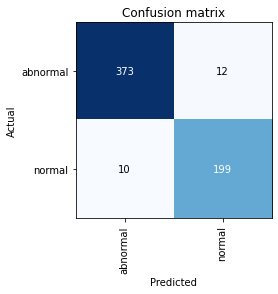

In [18]:
#@title **The confusion matrix**

#@markdown The _confusion matrix_ is a graphical representation of how the model performed.
#@markdown In our case, it is a 2x2 table comparing model predictions to the actual label for each class (i.e. "normal" and "abnormal").

interp.plot_confusion_matrix()

In [19]:
#@title **Analyzing the failures or "top losses"**

#@markdown The _loss function_ gives us a numerical value telling us how far off the model's prediction is from the actual class.
#@markdown The higher the loss, the more confused our model is.

#@markdown Analyzing the top losses can help you understand why your model fails when it fails.
#@markdown Here, we plot the top 3 losses for our test dataset.

interp.plot_top_losses(3)

,input,target,predicted,probability,loss
0,xxbos xxmaj no focal consolidation . xxmaj no visualized pneumothorax . xxmaj no large pleural effusions . xxmaj heart size normal . xxmaj cardiomediastinal silhouette is unremarkable . 1 . xxmaj no acute cardiopulmonary findings . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,abnormal,normal,0.9777563810348511,3.8056979179382324
1,xxbos xxmaj the heart size is normal . xxmaj no pneumothorax . xxmaj no large pleural effusions . xxmaj no focal airspace opacities . xxmaj no acute cardiopulmonary abnormalities . . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,abnormal,normal,0.9366915822029114,2.759737253189087
2,xxbos xxmaj the lungs appear clear . xxmaj heart and pulmonary xxrep 4 x appear normal . xxmaj mediastinal contours are normal . xxmaj pleural spaces are clear . xxmaj there appears to the contrast xxrep 4 x within small colonic xxunk in the splenic xxunk region . 1 . xxmaj no acute cardiopulmonary disease xxpad xxpad xxpad,normal,abnormal,0.9266363382339478,2.6123268604278564


# Language Model Text Generation

Just for fun, let's see how well our language model does at generating text. 
>**_NOTE_**: If you haven't trained the language model yet, you'll need to go back and do so now in order to proceed. Unfortunately, the language model is too big to save on GitHub...

In [20]:
#@title **Text Generator**

#@markdown Enter ~3-5 words to give our language model something to work with, then select other options and run the cell.

text = 'Normal heart size' #@param {type: "string"}
words_per_sentence = 18 #@param {type: "integer"}
num_sentences = 2 #@param {type: "integer"}

print('Generating predictions...')
preds = [learn_lm.predict(text, words_per_sentence, temperature=0.75) for _ in range(num_sentences)]
print()
for i, pred in enumerate(preds): print(f'Sentence {i + 1}: {pred}')

Generating predictions...



Sentence 1: Normal heart size . Normal mediastinal contour . No focal airspace consolidation . No pleural effusion or pneumothorax
Sentence 2: Normal heart size and mediastinal contours . Mild cardiomegaly . The lungs are clear . No pleural effusions


Looks like our generated text is pretty realistic! This helps us understand how the ULM-FiT approach results in a better text classification model.